In [1]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA,GradientDescent,COBYLA,ADAM
from qiskit.quantum_info import Statevector

import qiskit

In [2]:



# These specify the measurement directions and outcomes (each direction has two eigenstates)
x0=Statevector([1/np.sqrt(2),1/np.sqrt(2)])
x1=Statevector([1/np.sqrt(2),-1/np.sqrt(2)])
z0=Statevector([1,0])
z1=Statevector([0,1])

measurement_list=[z0,z1,x0,x1]

def get_operator_list(measurement_list):
    op_list=[]
    for state in measurement_list:
        operator=np.outer(state,state)
        operator=operator/(len(measurement_list)/2)
        op_list.append(operator)
        
    return op_list


In [3]:
# Form the projectors (measurement operators corresponding to those directions and outcomes ) : 4 operators for 4 outcomes
op_list=get_operator_list(measurement_list)
op_list

[array([[0.5+0.j, 0. +0.j],
        [0. +0.j, 0. +0.j]]),
 array([[0. +0.j, 0. +0.j],
        [0. +0.j, 0.5+0.j]]),
 array([[0.25+0.j, 0.25+0.j],
        [0.25+0.j, 0.25+0.j]]),
 array([[ 0.25+0.j, -0.25+0.j],
        [-0.25+0.j,  0.25-0.j]])]

In [4]:




class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept=None):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)


class GDOptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, norm):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)




def cost_function(frequency_data,parameters):
    '''
    cost_function for optimizer.
    Given parameters for some quantum state (rho) this gives the log_likelihood of getting the frequencies that are given as input.
    
    Loss = sum_over_i of {-frequency[i]*log(Tr(rho*operator[i])}
    '''
    
    loss=0
    x=parameters[0]
    z=parameters[1]
    rho=0.5*np.array([[1+z,x],[x,1-z]])   # a state on a bloch sphere at some (x,y=0,z) has this matrix representation
    i=0
    for key,value in frequency_data.items():
       
        
        
        operator=op_list[i]
        
        predicted_prob= np.trace(np.matmul(rho,operator))    # Rule to calculate probabilities from a given state rho and measurement operator
        
        
        loss=loss-value*np.log(np.abs(predicted_prob))     #loss function as defined in the reference shared on MLE, this is called the log likelihood
        i+=1
    
    #loss=loss+1000*(np.linalg.norm(parameters) - 1)**2       #add for constraint that the state lies on the bloch sphere
    return loss

        
def objective_function(parameters):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    
    return cost_function(frequency_data , parameters)

#
## The  frequencies we want (target frequencies) given as dictionary. Can change later (for arbitary directions)
## x1/x0 is the number of outcomes with output '1' / '0' when measuring along x


In [5]:
frequency_data={'z0':0.25, 'z1':0.25 ,'x0':0.5 ,'x1':0.0}
# frequency_data = {'z0':0.25, 'z1':0.25 }   for single basis


In [6]:
# Set and optimizer
SPSA_log=OptimizerLog()

optimizer_SPSA = SPSA(maxiter=200, callback=SPSA_log.update)
optimizer_GD=GradientDescent(maxiter=100,callback=SPSA_log.update,perturbation=0.1,learning_rate=0.3)

In [7]:
num_params=2   # Two parameters for x and z coordinate of the state on bloch sphere
repeat=True
while(repeat):
    initial_point=np.random.random(num_params)    # To get a state inside the bloch sphere only
    if np.linalg.norm(initial_point)<1:
        repeat=False

initial_point=[-0.9, 0.0]    #Setting the initial point manually

result_SPSA=optimizer_GD.minimize(objective_function,initial_point,bounds=[(-1,1),(-1,1)])
print(initial_point)

[-0.9, 0.0]


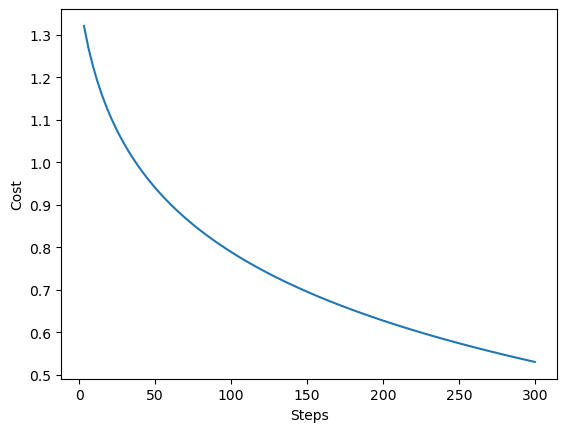

0.530065976663423
final parameters , x and z : [ 4.54950278 -0.05      ]
300


In [8]:
opt_var = result_SPSA.x
opt_value = result_SPSA.fun
y=result_SPSA.nfev

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(SPSA_log.evaluations, SPSA_log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()
print(opt_value)
print('final parameters , x and z :' ,opt_var)
print(y)

In [9]:
print('Norm of state = ', np.linalg.norm(opt_var))   # Should be less than 1, for state inside the sphere

param_history=np.array(SPSA_log.parameters)




Norm of state =  4.5497775228334865


In [10]:
def cost_line(frequency_data,X,Y):
    return [cost_function(frequency_data,[x,y]) for x,y in zip(X,Y)]

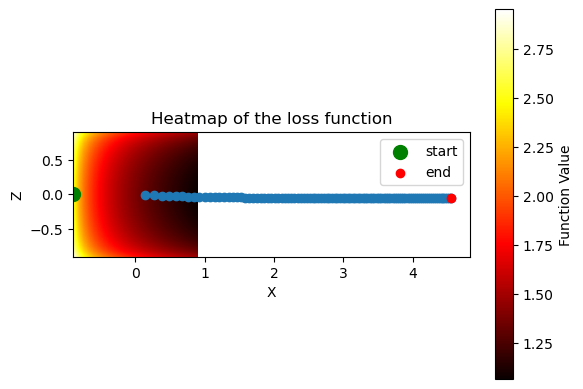

In [15]:

import numpy as np
import matplotlib.pyplot as plt

x_range=[-0.9,0.9]
    # Generate coordinate arrays
x = np.linspace(x_range[0],x_range[1], 100)
z = np.linspace(x_range[0],x_range[1], 100)

    # Create a grid of coordinate pairs
X, Z = np.meshgrid(x, z)

F=[cost_line(frequency_data,x,z) for x,z in zip(X,Z)]
plt.imshow(F, cmap='hot', origin='lower',extent=[x_range[0], x_range[1],x_range[0],x_range[1]])
plt.colorbar(label='Function Value')  # Add colorbar with label
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Heatmap of the loss function')
plt.scatter(initial_point[0],initial_point[1],c='g',label='start',s=100)
plt.scatter(param_history[:,0], param_history[:,1])
plt.scatter(param_history[-1,0],param_history[-1,1],c='r',label='end')
plt.legend()
plt.show()

In [ ]:
## There was some bug in the The algorithm is actually working fine

In [12]:
cost_function(frequency_data,[0,0])

1.3862943611198908

In [13]:
def new_objective_function(parameters):
    
    t1=parameters[0]
    t2=parameters[1]
    t3=parameters[2]
    T=np.array([[0,t1],[t2,t3]],dtype=np.complex128)
    T_=np.transpose(np.conj(T))
    
    rho=np.matmul(T,T_)   # a state on a bloch sphere at some (x,y=0,z) has this matrix representation
    i=0
    loss=0
    for value in frequency_data:
       
        
        
        operator=op_list[i]
        
        predicted_prob= np.trace(np.matmul(rho,operator))    # Rule to calculate probabilities from a given state rho and measurement operator
        
        
        loss=loss-value*np.log(np.abs(predicted_prob))     #loss function as defined in the reference shared on MLE, this is called the log likelihood
        i+=1
    
    #loss=loss+1000*(np.linalg.norm(parameters) - 1)**2       #add for constraint that the state lies on the bloch sphere
    return loss
